In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ticktack
from jax import jit
import jax.numpy as jnp
from ticktack import fitting, resample
from scipy.interpolate import interp1d
plt.rcParams['figure.figsize'] = (8.0, 6.0)
#from helper import run_resample, load_IntCal20
import pandas as pd
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
import statistics
import scipy.signal

In [2]:
data = pd.read_csv("../data/brehm21_edit.csv")
## fake data!
#data.d14c = np.random.randn(len(data.d14c))*data.sig_d14c

#ndata = 1000
#data = pd.DataFrame({'year':np.arange(ndata),
#                     'd14c':np.random.randn(ndata),
#                     'sig_d14c':np.ones(ndata)})

<ErrorbarContainer object of 3 artists>

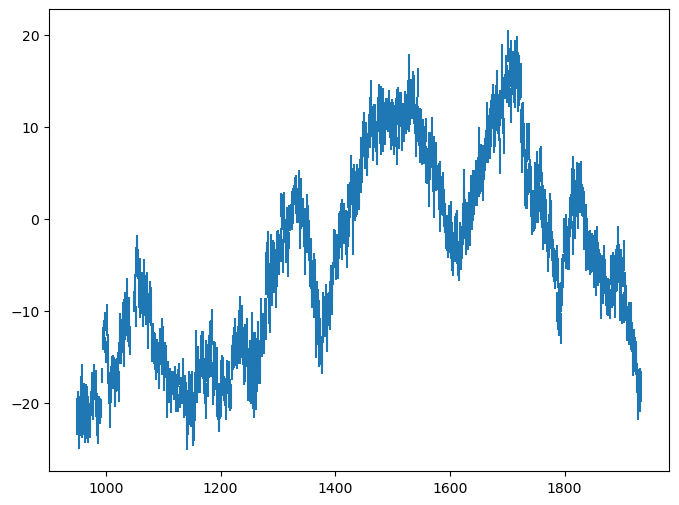

In [3]:
plt.errorbar(data.year, data.d14c, yerr=data.sig_d14c, linestyle='None')

In [4]:
class Resampler:

    def load_data(self, x, y, yerr):
        self.x = x
        self.y = y
        self.yerr = yerr
        self.start = np.nanmin(self.x)
        self.end = np.nanmax(self.x)
        self.annual = jnp.arange(self.start, self.end + 1)

    def super_gaussian(self, x, sz, order=30):
        return np.exp(-(x / sz) ** order)

    def bandpass_super_gaussian(self, signal, l, sz, order=30):
        if np.ndim(signal) == 1:
            signal = signal.reshape(1, -1)
        n = signal.shape[1]
        freq = fftfreq(n, d=1)
        mask = self.super_gaussian(np.abs(freq) - l, sz, order=order).reshape(1, -1)
        new_signal = ifft(fft(signal) * mask)
        return np.abs(np.squeeze(new_signal))

    def signal_resample(self, size=10000, l=1./9.677, sz=0.05, order=30, samples=None):
        if not np.all(samples):
            samples = np.random.multivariate_normal(self.y, np.diag(self.yerr ** 2), size=size)
        f = interp1d(self.x, samples, kind="cubic")
        interpolation = f(self.annual)
        new_sig = self.bandpass_super_gaussian(interpolation, l, sz, order=order)
        return new_sig



In [36]:
resampler = resample.Resampler()
resampler.load_data(data.year, data.d14c, data.sig_d14c)
samples = np.random.multivariate_normal(resampler.y, np.diag(resampler.yerr ** 2), size=10000)
print(samples.shape)

(10000, 968)


In [6]:
#plt.hist(resampler.y+np.random.randn(len(resampler.y)),bins=25)

In [7]:
from scipy.fft import fft, ifft, fftfreq


In [37]:
n = samples.shape[1]
freq = fftfreq(n, d=1)
mask = resampler.super_gaussian(np.abs(freq) - 1/9.677, 0.05, order=30).reshape(1, -1)
new_signal = ifft(fft(samples) * mask)



/tmp/ipykernel_318927/891392498.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freq,(fft(samples)*mask).real.mean(axis=0))
/tmp/ipykernel_318927/891392498.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.fill_between(1/freq,(fft(samples)*mask).real.mean(axis=0) - (fft(samples)*mask).real.std(axis=0),


(10000, 968) (1, 968)


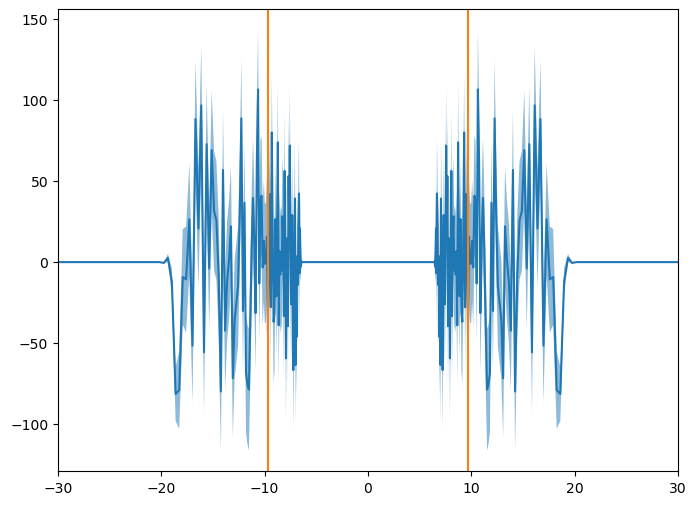

In [38]:
plt.plot(1/freq,(fft(samples)*mask).real.mean(axis=0))
plt.fill_between(1/freq,(fft(samples)*mask).real.mean(axis=0) - (fft(samples)*mask).real.std(axis=0),
                 (fft(samples)*mask).real.mean(axis=0) + (fft(samples)*mask).real.std(axis=0),alpha=0.5)
plt.xlim(-30,30)
plt.axvline(9.677,color='C1')
plt.axvline(-9.677,color='C1')
print(samples.shape,mask.shape)

/tmp/ipykernel_318927/1214827260.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freq,(fft(samples)*mask).real.mean(axis=0))


(-30.0, 30.0)

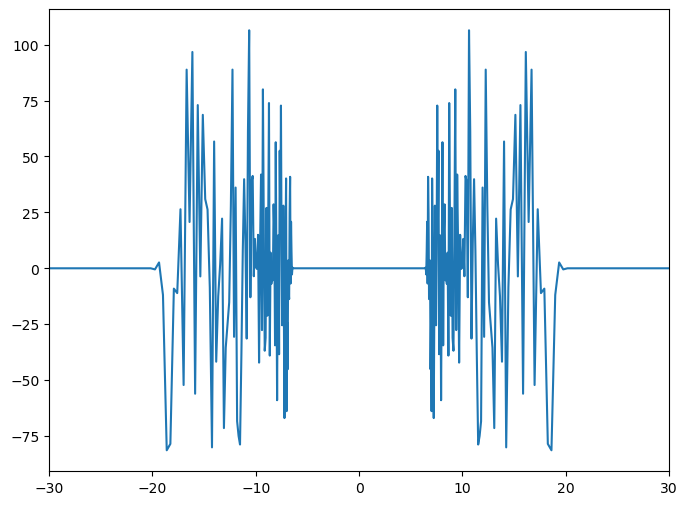

In [10]:
plt.plot(1/freq,(fft(samples)*mask).real.mean(axis=0))
plt.xlim(-30,30)

In [11]:
data.d14c

0     -21.436972
1     -20.157079
2     -21.376327
3     -22.889835
4     -21.349848
         ...    
963   -17.928279
964   -19.057246
965   -17.843584
966   -19.304655
967   -18.211613
Name: d14c, Length: 968, dtype: float64

In [12]:
resampler = resample.Resampler()
resampler.load_data(data.year, data.d14c, data.sig_d14c)
resampler.annual = np.arange(np.ceil(resampler.start), np.floor(resampler.end + 1))
new_signal = resampler.signal_resample(size=512)

In [13]:
f = interp1d(resampler.x, resampler.y, kind="cubic")
interpolation = f(resampler.annual)
sig = resampler.bandpass_super_gaussian(interpolation, l=1./9.677, sz=0.05, order=30)

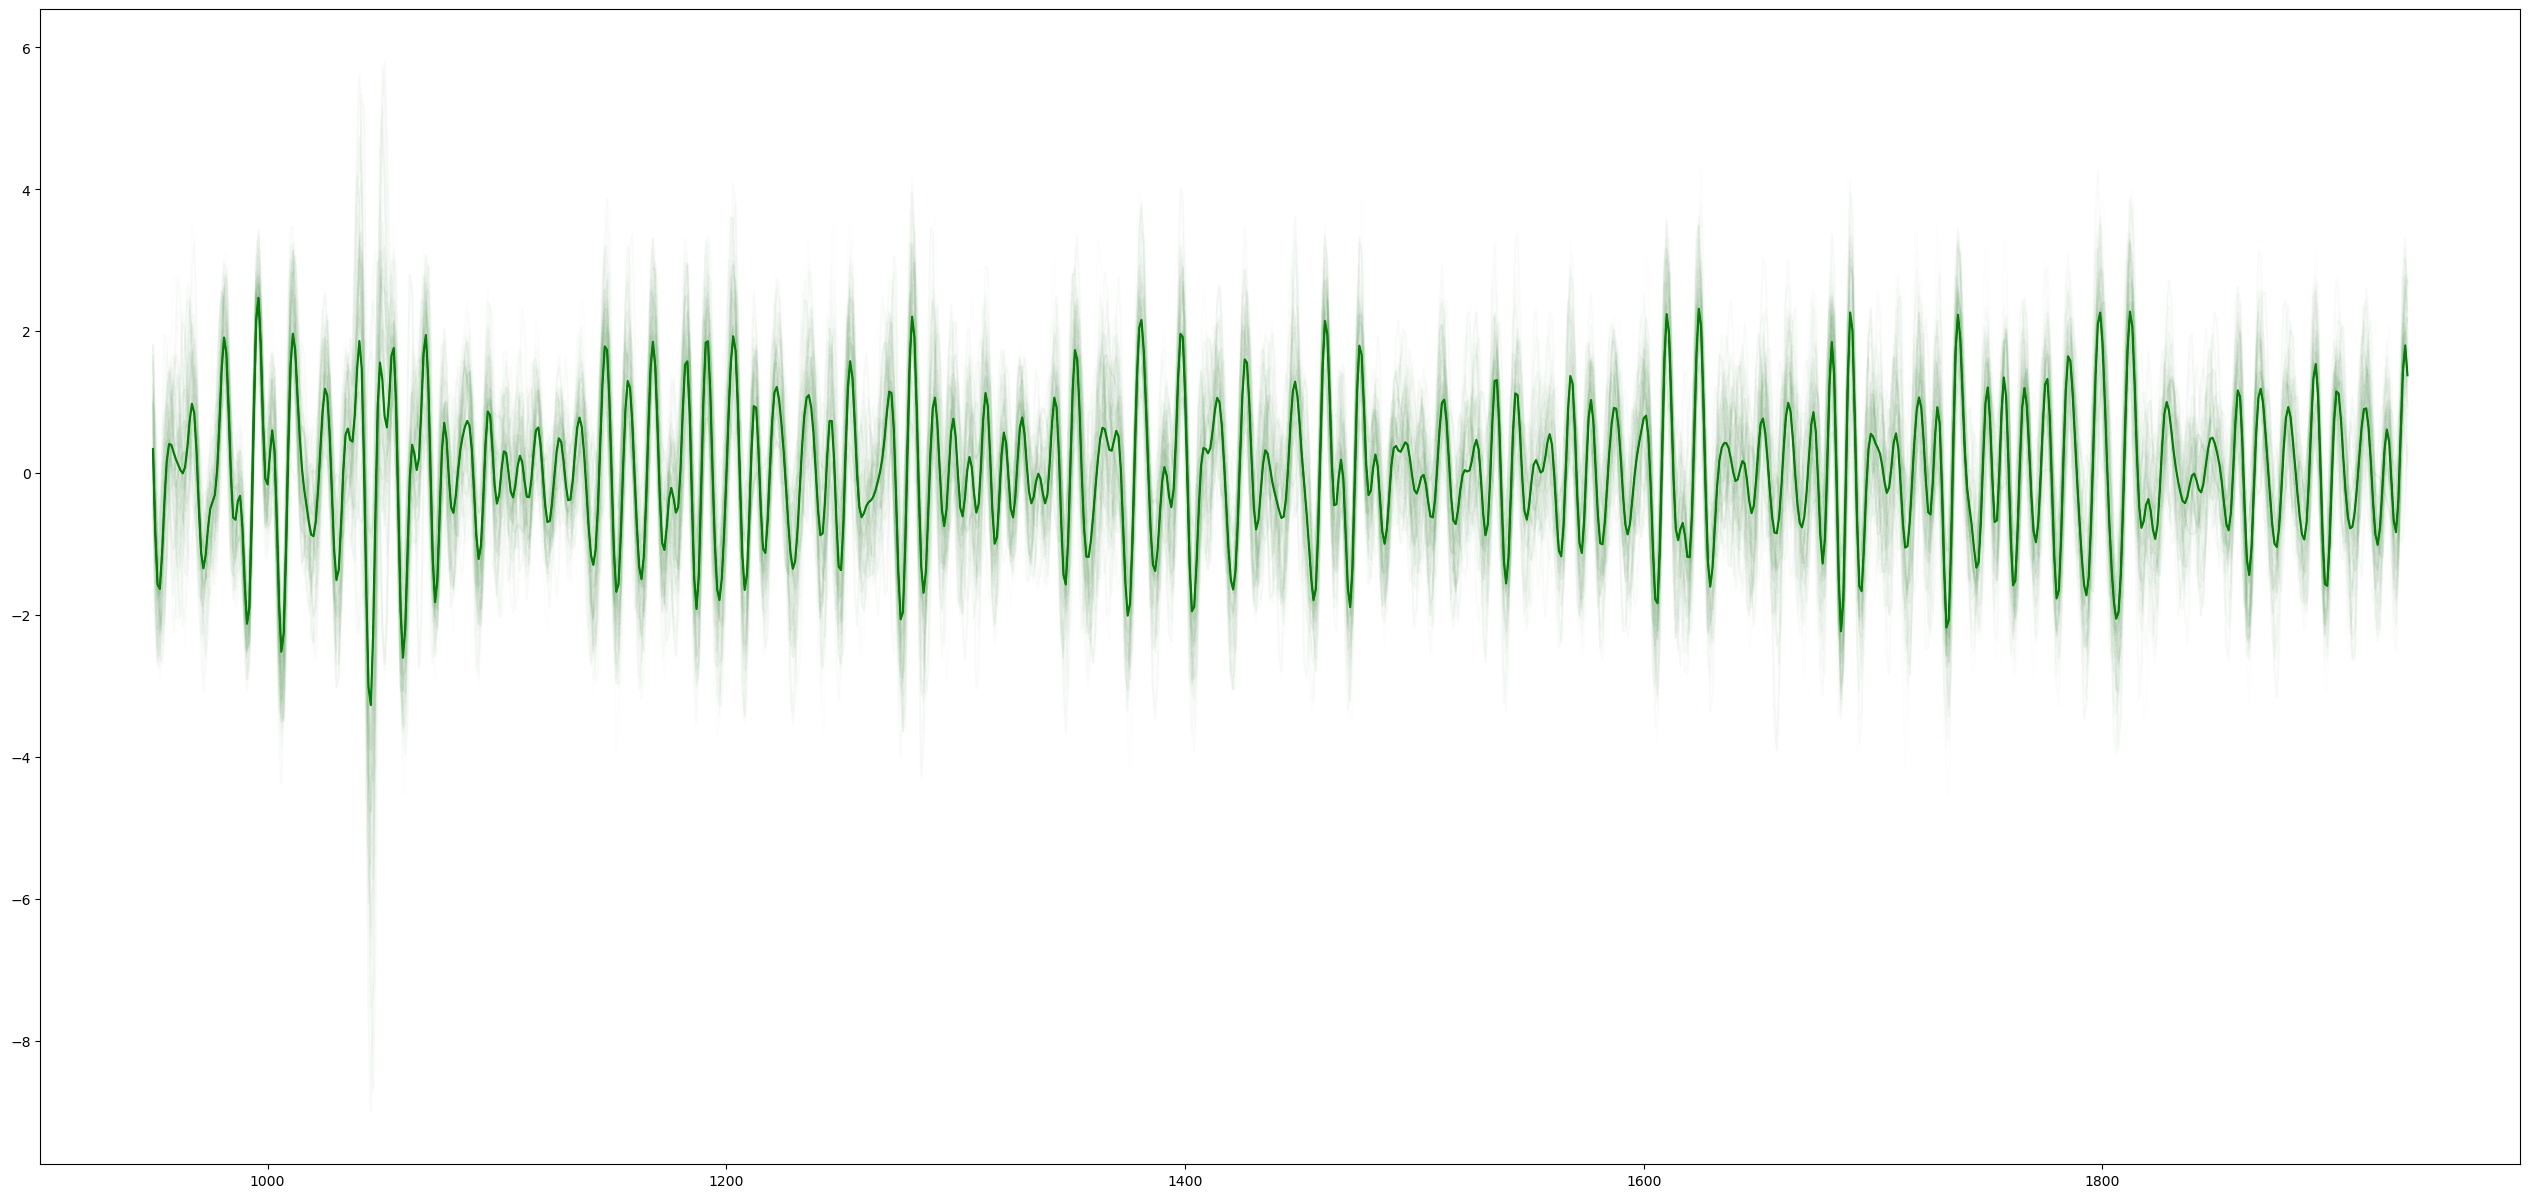

In [14]:
fig, axs = plt.subplots(1, figsize=(32, 15), sharex=True)
axs.plot(resampler.annual, sig, color="g")
for i in np.random.randint(100, size=100):
    axs.plot(resampler.annual, new_signal[i, :], color="g", alpha=0.01)

#plt.xlim(0,100)
# axs.axvline(1520)
# axs.axvline(1540)
# axs.axvline(1560)
# axs.axvline(1580)
# axs.axvline(1600)

[[ 1.19038212 -0.31669498 -1.5789016  ...  1.81185829  2.62513784
   2.35728426]
 [-0.41092126 -1.27972472 -1.38650665 ...  1.94185332  1.76422919
   0.81702982]
 [ 1.36417024  0.65815431 -0.35259246 ...  0.43778953  1.10545855
   1.50255199]
 ...
 [-1.12462479 -2.33524944 -2.50073199 ...  1.05270881  1.14712416
   0.3149569 ]
 [-0.21306347 -0.98104307 -1.30301301 ...  1.51074928  1.41767715
   0.72726023]
 [ 0.1711278  -1.58760963 -2.30051039 ...  2.01771942  2.72754648
   1.96842925]]


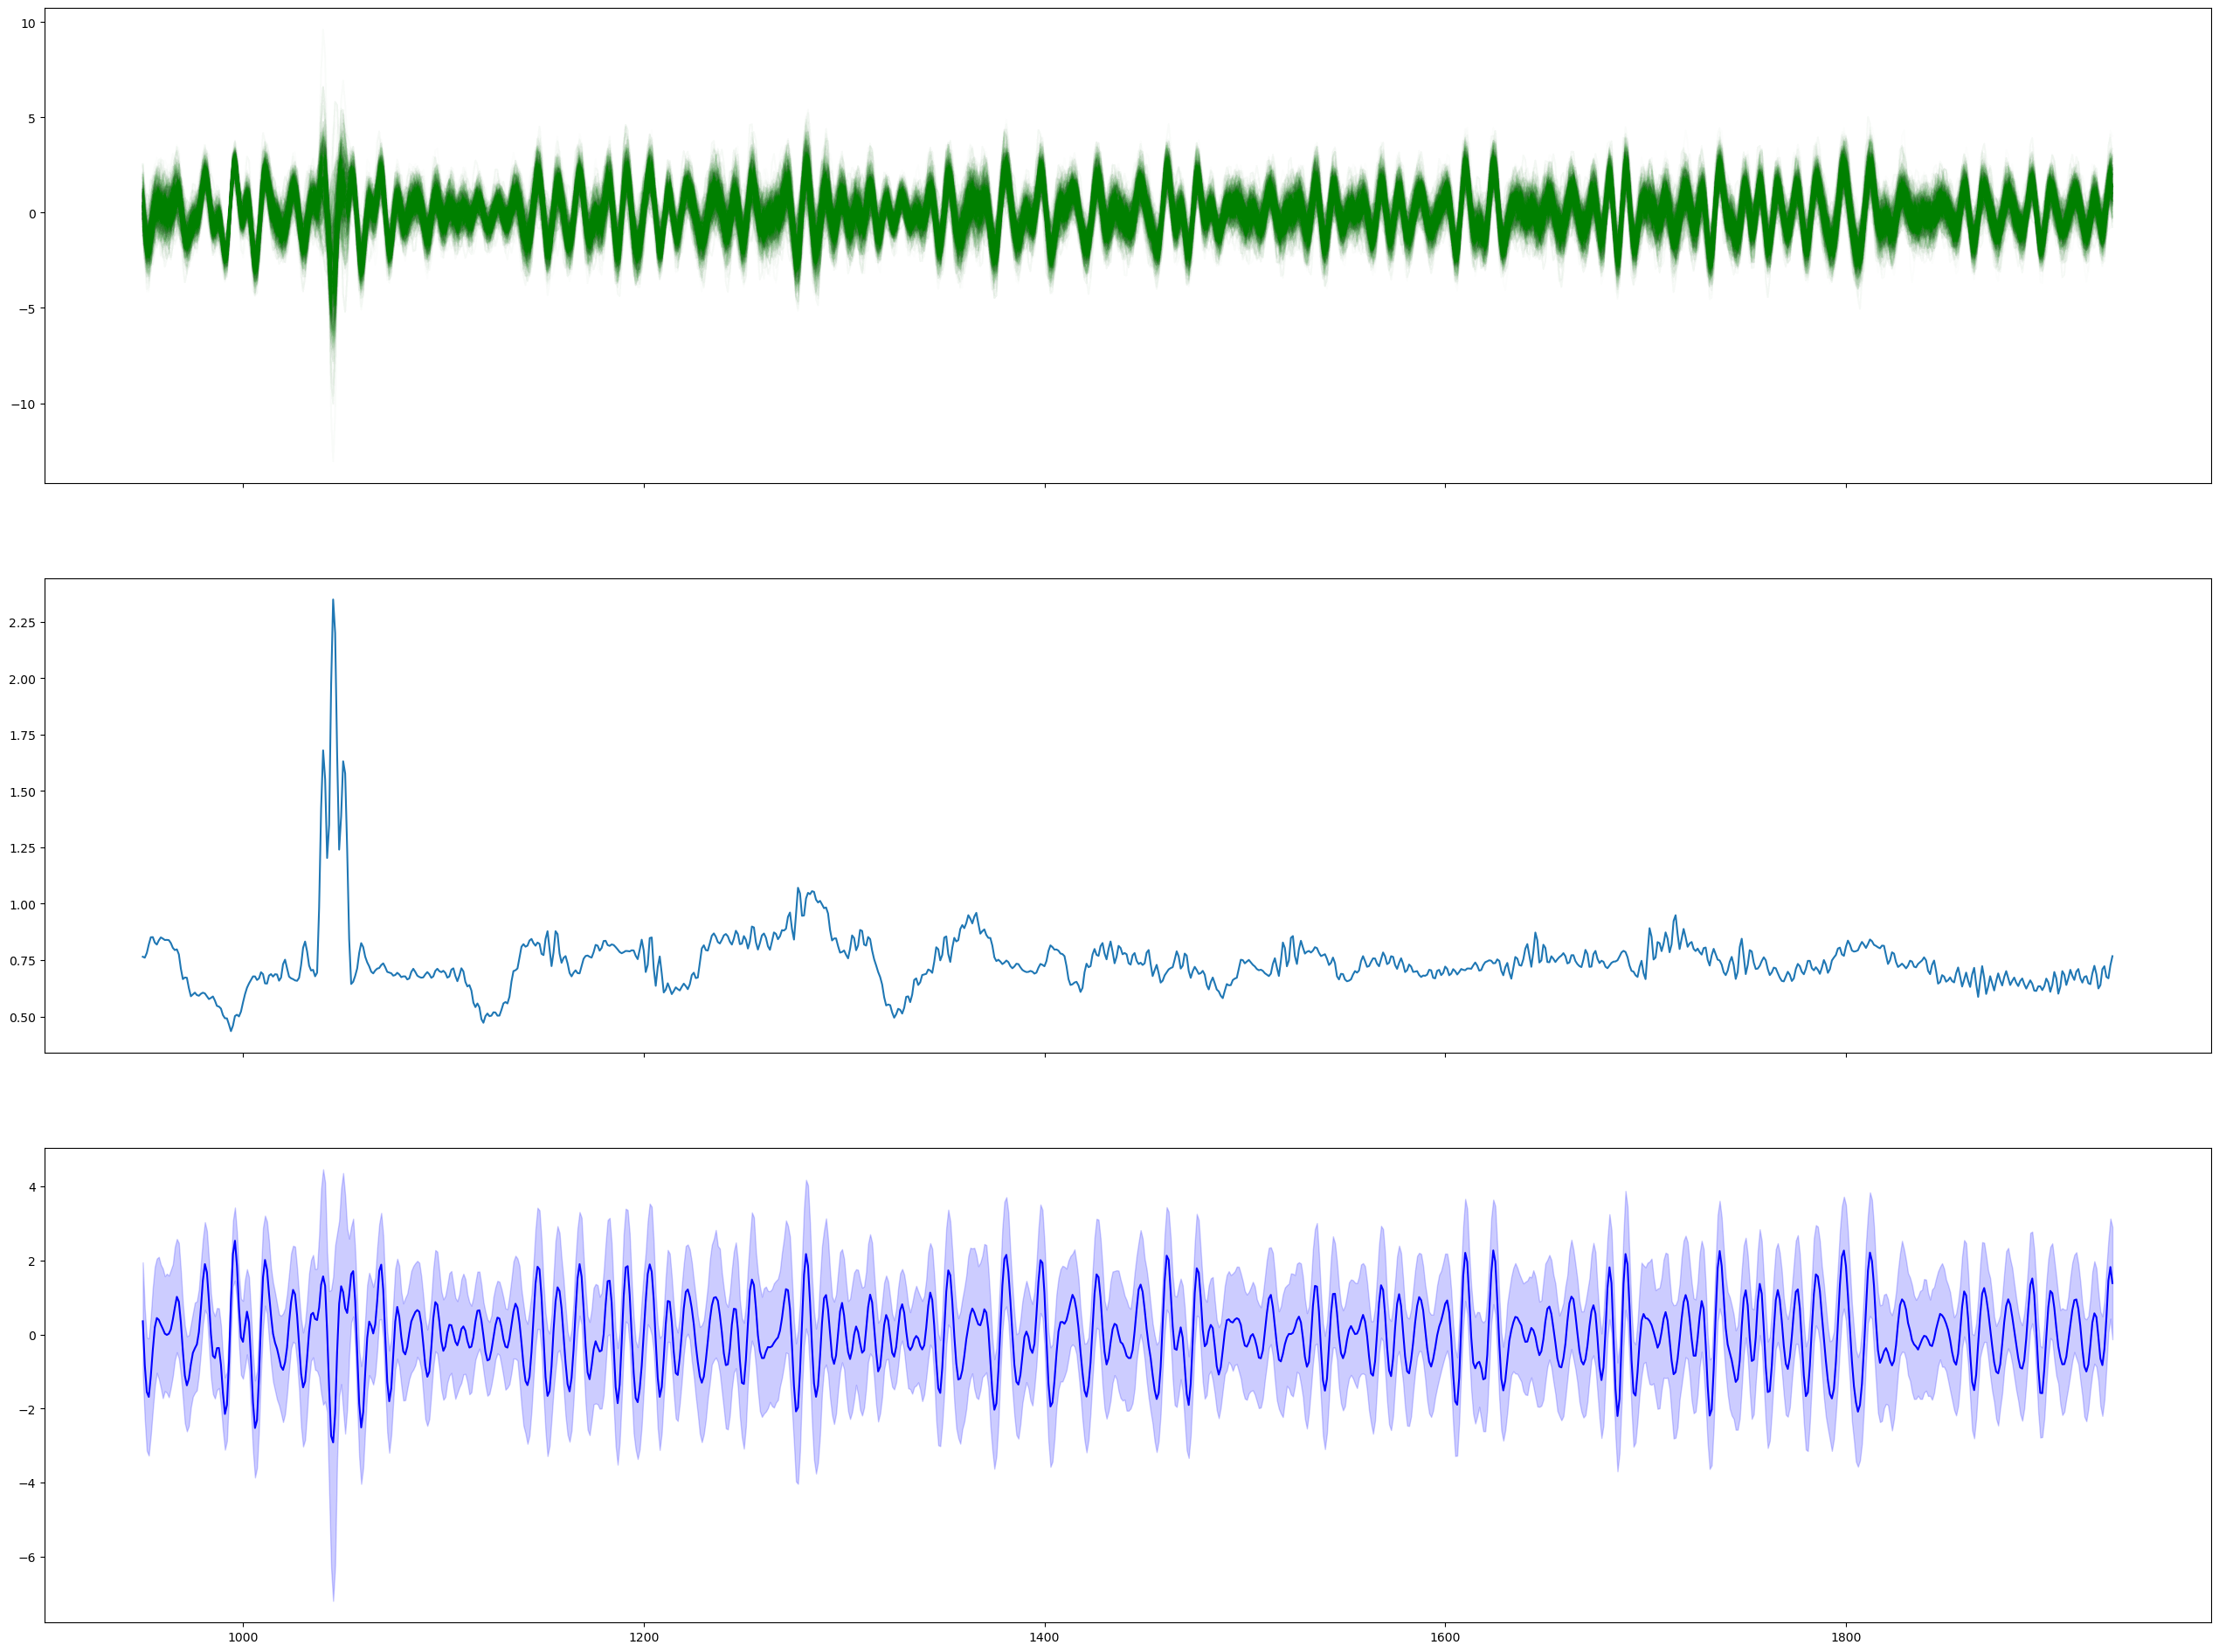

In [15]:
fig, axs = plt.subplots(3, figsize=(32, 24), sharex=True)
for i in np.random.randint(512, size=1000):
    axs[0].plot(resampler.annual, new_signal[i, :], color="g", alpha=0.01)
axs[0].plot(resampler.annual, sig, color="g")
axs[1].plot(resampler.annual, np.std(new_signal, axis=0))
l, m, u = np.percentile(new_signal, (2.5, 50, 97.5 ), axis=0)
axs[2].fill_between(resampler.annual, l, u, color = 'b', alpha=0.2)
axs[2].plot(resampler.annual, m, color = 'b')
print(new_signal)

[ 5.25088808e-18 -8.59655115e-18 -1.96709973e-18  4.18762071e-18
 -3.94731126e-18  9.70724549e-18  1.10839839e-17  2.06857841e-18
  9.83184197e-18  4.36226100e-18  9.11170557e-18  1.04010688e-17
 -3.03736374e-18 -2.03028977e-18  4.37411946e-18  1.69082651e-17
 -4.26320635e-18 -5.71189437e-19  9.95394556e-18  2.65965591e-18
  5.09927607e-19 -1.30533975e-18  9.33912359e-18  6.82804966e-18
  4.80927403e-18  9.46208798e-18  3.67703200e-18  1.31505790e-17
  1.32694116e-17  2.77661532e-18 -3.02651070e-18  7.64737154e-18
 -7.38006723e-19 -8.74826646e-18  1.35282869e-17  7.63348847e-18
  2.27583291e-19 -5.51797203e-18  3.48751699e-18  1.67996245e-17
  1.06507438e-17  1.07327200e-17  8.96207686e-18  1.02338108e-18
  2.28321518e-18  6.72822373e-18 -3.79602980e-18 -5.68126346e-18
  1.15792021e-17  1.38998244e-17  5.16990347e-18  3.64750292e-18
  5.06225453e-18  3.27458806e-18  7.26418210e-18 -4.16007492e-18
  2.85737957e-18 -1.64371220e-18 -8.52459467e-19 -8.93750602e-19
  6.84281420e-18  7.57619

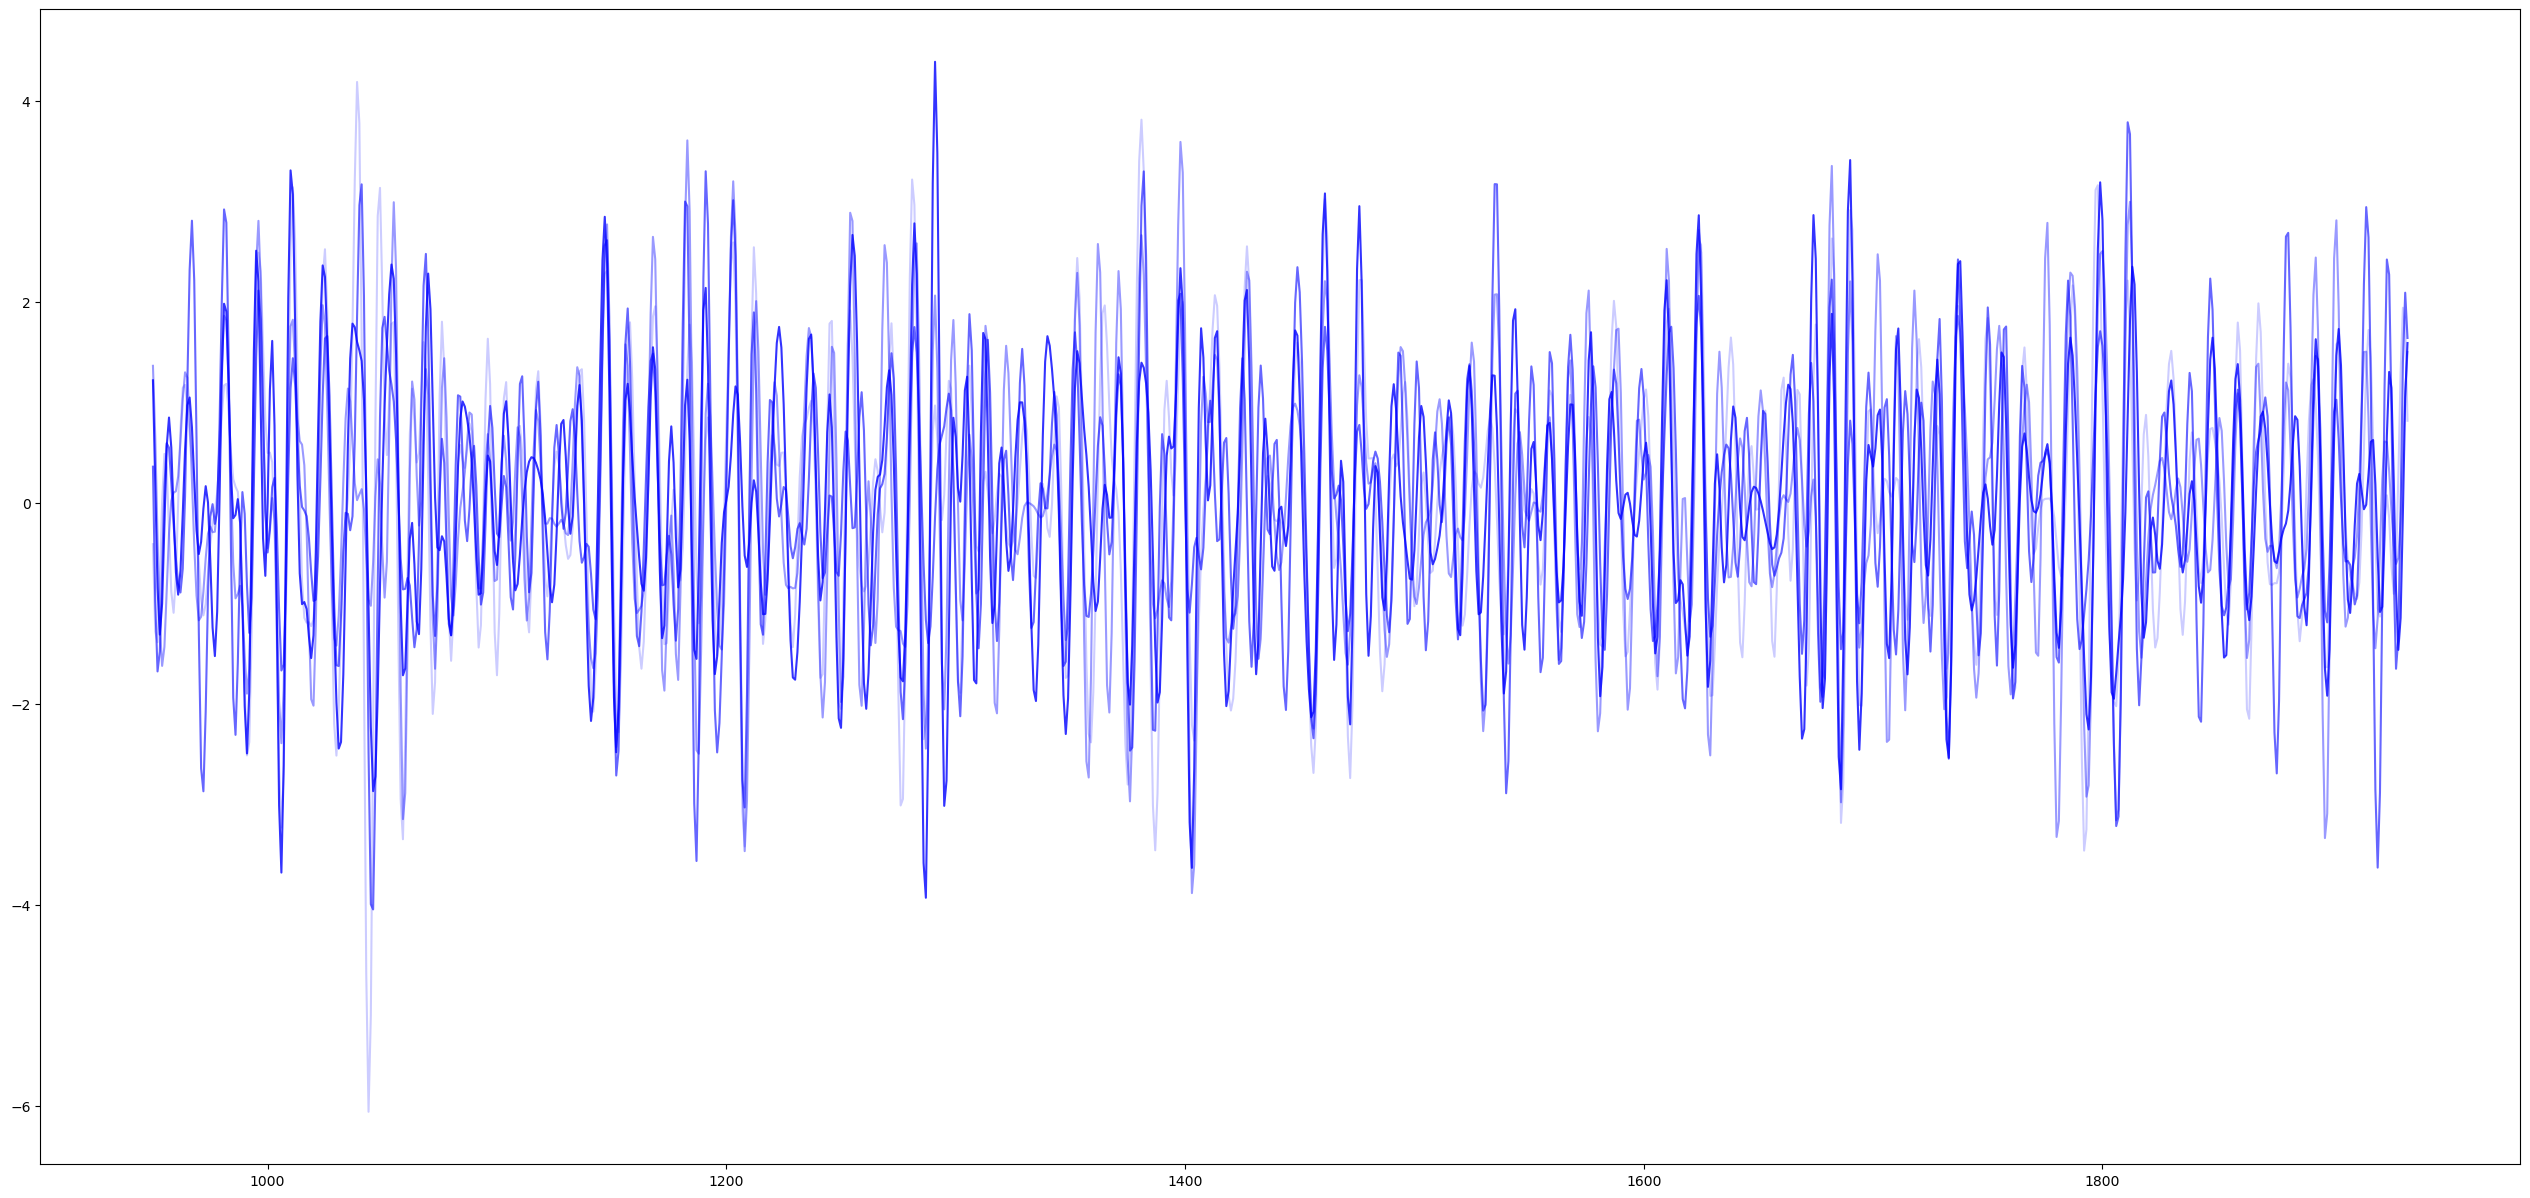

In [16]:
fig, axs = plt.subplots(1, figsize=(32, 15), sharex=True)
for i in range(5):
    axs.plot(resampler.annual,new_signal[i,:],color="b", alpha=0.2*i)
means = np.zeros(100)
zero_signal=new_signal
for i in range(100):
    means[i]=statistics.mean(new_signal[i,:])
    zero_signal[i,:]-=means[i]
print(means)
print(zero_signal)

In [17]:
%%time
norm_signal=zero_signal.copy()
for i in range(512):
    norm_signal[i,:]=norm_signal[i,:]/np.sqrt((norm_signal[i,:]**2).sum())


CPU times: user 9.02 ms, sys: 0 ns, total: 9.02 ms
Wall time: 6.91 ms


In [18]:
%%timeit 
sumy=0
for p in range(101):
    sumy+=float(new_signal[i,p])**2

23.5 μs ± 3.53 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [19]:
%%timeit 
(new_signal[i,:]**2).sum()

3.44 μs ± 1.14 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [20]:
# interesting1 = norm_signal[0,:]
# dotprods=np.zeros(10000)
# newest=np.vstack([dotprods,dotprods,dotprods,dotprods,dotprods])
# for w in range(0,5):
#     recheck=np.zeros(10000)
#     interesting2=norm_signal[w,:]
#     for v in range(0,10000):
#         dotprod=0
#         for i in range(101):
#             dotprod+=interesting2[i]*norm_signal[v,i]
#         recheck[v]=dotprod
#     newest[w]=recheck
# print(newest)

In [21]:
covmat = np.corrcoef(norm_signal)

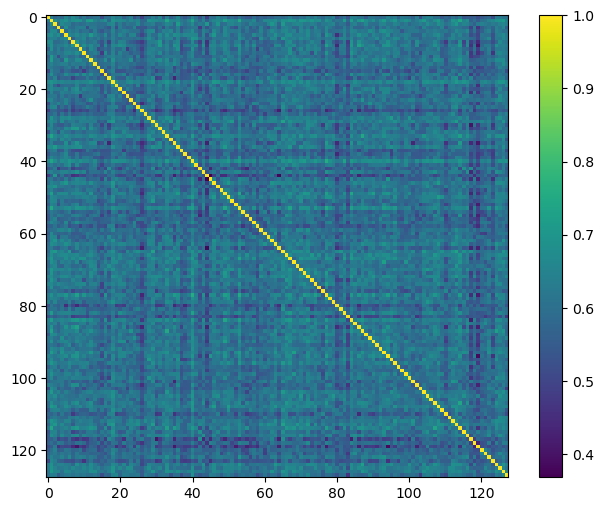

In [22]:
plt.imshow(covmat[:128,:128])
plt.colorbar()

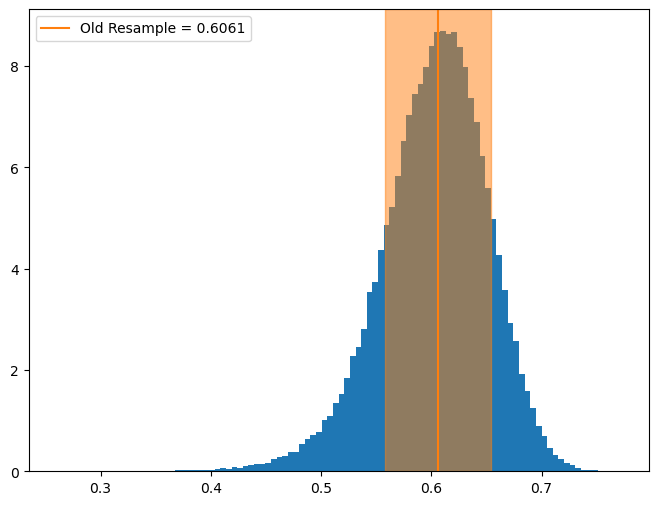

In [23]:
off_diag = covmat[~np.eye(covmat.shape[0],dtype=bool)]
plt.hist(off_diag,bins=100,density=True);
m, s = np.nanmedian(off_diag), np.nanstd(off_diag)
label2='Old Resample = '+str(round(m,4))
plt.axvline(m,color='C1',label=label2)
plt.axvspan(m-s,m+s,color='C1',alpha=0.5)
plt.legend()


In [24]:
from scipy.ndimage import gaussian_filter1d as gaussfilt
from scipy.ndimage import uniform_filter1d as unifilt


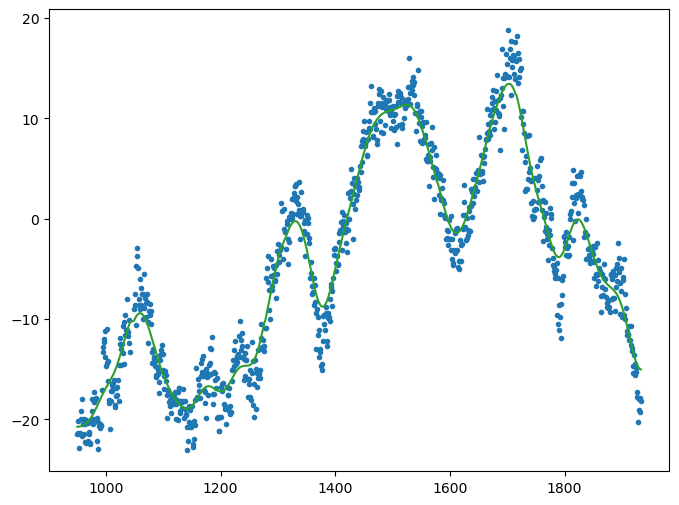

In [25]:
savgol=scipy.signal.savgol_filter(data.d14c,75,3)
gauss = gaussfilt(data.d14c,15)
uni=unifilt(data.d14c,15)
plt.plot(data.year,data.d14c,'.')
#plt.plot(data.year,savgol,color='C1')
plt.plot(data.year,gauss,color='C2')
#plt.plot(data.year,uni,color='C3')
# plt.plot(data.year,gauss,color='C2')
# plt.plot(data.year,data.d14c-savgol,'.C1')
# plt.plot(data.year,data.d14c-gauss,'.C2')

#newer=data.d14c-checking
#plt.plot(data.year,newer)
# plt.axvline(993)

In [26]:
mask = ~((data.year >  992)  * (data.year < 1000))
newdata = pd.DataFrame({'year':data.year[mask],
            'd14c':data.d14c[mask],
           'sig_d14c':data.sig_d14c[mask]})
heavy_clipping=[3,8,35,36,42,50,51,52,53,57,92,97,98,99,100,120,186,201,219,229,298,301,305,322,323,325,347,356,406,460,467,469,502,
                      547,566,583,602,611,661,687,723,727,730,737,742,751,759,765,767,768,785,791,792,796,805,821,823,824,825,826,827,828,
                      829,848,849,898,927,937]
loose_clipping=[51,99,469,583,661,723,727,730,827]
newdata=newdata.drop(heavy_clipping)
pd.DataFrame.reset_index(newdata);

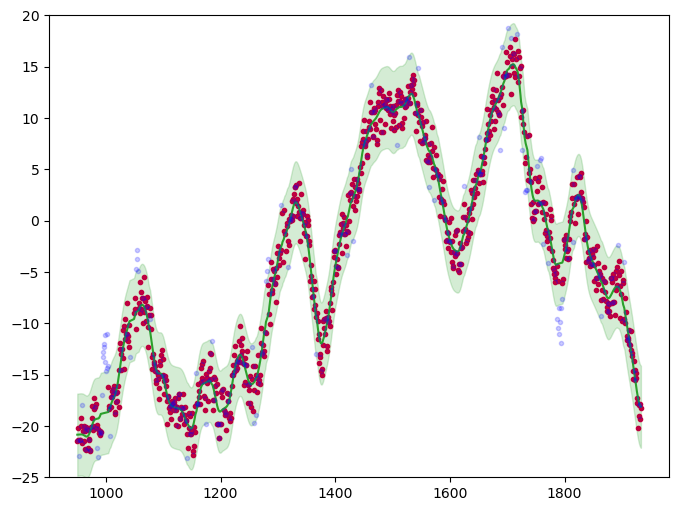

In [27]:
newgauss = gaussfilt(newdata.d14c,5)
plt.plot(newdata.year,newdata.d14c,'.',color='r')
plt.plot(newdata.year,newgauss,color='C2')
plt.fill_between(newdata.year,newgauss-4,newgauss+4,color='C2',alpha=0.2)
plt.ylim(-25,20)
plt.plot(data.year,data.d14c,'.',color='b',alpha=0.2)


/tmp/ipykernel_318927/78176331.py:9: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freq2,(fft(samples2)*mask2).real.mean(axis=0),color='C1',alpha=0.5)
/tmp/ipykernel_318927/78176331.py:10: RuntimeWarning: divide by zero encountered in divide
  plt.fill_between(1/freq2,(fft(samples2)*mask2).real.mean(axis=0) - (fft(samples2)*mask2).real.std(axis=0),
/tmp/ipykernel_318927/78176331.py:16: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freq,(fft(samples)*mask).real.mean(axis=0),color='C0',alpha=0.5)
/tmp/ipykernel_318927/78176331.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.fill_between(1/freq,(fft(samples)*mask).real.mean(axis=0) - (fft(samples)*mask).real.std(axis=0),


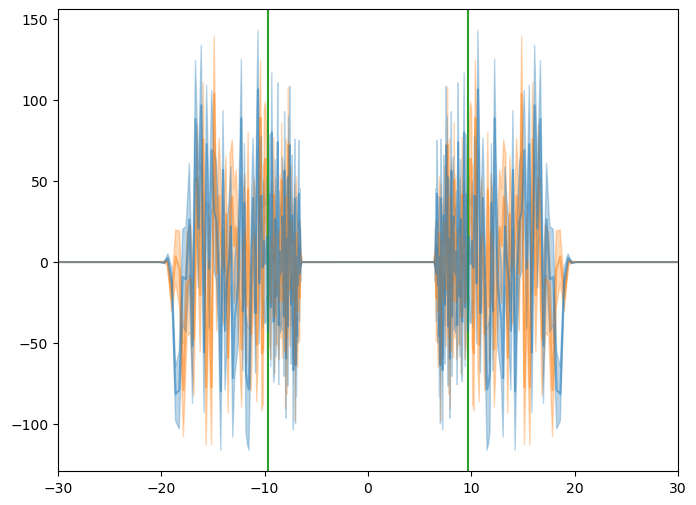

In [40]:
resampler = resample.Resampler()
resampler.load_data(newdata.year, newdata.d14c, newdata.sig_d14c)
samples2 = np.random.multivariate_normal(resampler.y, np.diag(resampler.yerr ** 2), size=10000)
n2 = samples2.shape[1]
freq2 = fftfreq(n2, d=1)
mask2 = resampler.super_gaussian(np.abs(freq2) - 1/9.677, 0.05, order=30).reshape(1, -1)
new_signal2 = ifft(fft(samples2) * mask2)

plt.plot(1/freq2,(fft(samples2)*mask2).real.mean(axis=0),color='C1',alpha=0.5)
plt.fill_between(1/freq2,(fft(samples2)*mask2).real.mean(axis=0) - (fft(samples2)*mask2).real.std(axis=0),
                 (fft(samples2)*mask2).real.mean(axis=0) + (fft(samples2)*mask2).real.std(axis=0),color='C1',alpha=0.3)
plt.xlim(-30,30)
plt.axvline(9.677,color='C2')
plt.axvline(-9.677,color='C2')

plt.plot(1/freq,(fft(samples)*mask).real.mean(axis=0),color='C0',alpha=0.5)
plt.fill_between(1/freq,(fft(samples)*mask).real.mean(axis=0) - (fft(samples)*mask).real.std(axis=0),
                 (fft(samples)*mask).real.mean(axis=0) + (fft(samples)*mask).real.std(axis=0),color='C0',alpha=0.3)

/tmp/ipykernel_318927/640944542.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freq2,(np.abs((fft(samples2)*mask2)).mean(axis=0))**2,color='C1',alpha=0.5)
/tmp/ipykernel_318927/640944542.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1/freq,(np.abs((fft(samples)*mask)).mean(axis=0))**2,color='C0',alpha=0.5)


(-25.0, 25.0)

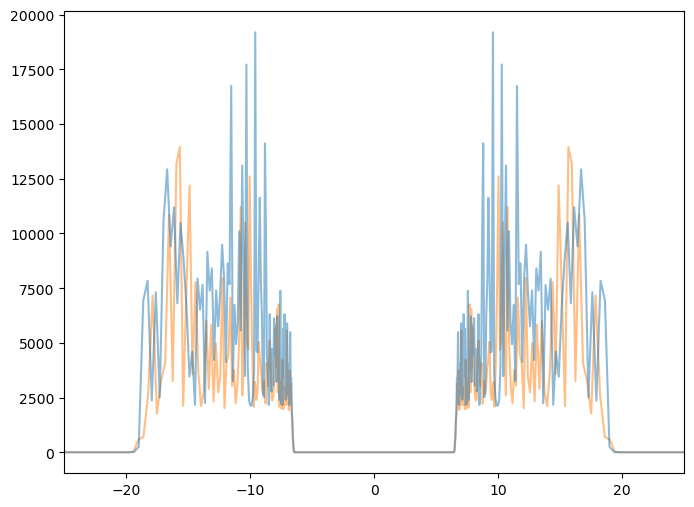

In [45]:
plt.plot(1/freq2,(np.abs((fft(samples2)*mask2)).mean(axis=0))**2,color='C1',alpha=0.5)
plt.plot(1/freq,(np.abs((fft(samples)*mask)).mean(axis=0))**2,color='C0',alpha=0.5)
plt.xlim(-25,25)

In [ ]:
def resample_signal(data_frame):
    resampler = resample.Resampler()
    resampler.load_data(data_frame.year, data_frame.d14c, data_frame.sig_d14c)
    resampler.annual = np.arange(np.ceil(resampler.start), np.floor(resampler.end + 1))
    new_signal = resampler.signal_resample(size=512)
    return(new_signal)
def norm_zero_signal(data_frame):
    new_signal=resample_signal(data_frame)
    zero_signal=new_signal.copy()
    nsamples = new_signal.shape[0]
    zero_signal -= new_signal.mean(axis=1)[:,None]
    norm_signal=zero_signal/np.sqrt((zero_signal**2).sum(axis=1))[:,None]
    return(norm_signal)
def covarience_matrix(data_frame):
    covmat = np.corrcoef(norm_zero_signal(data_frame))
    return(covmat)
def remove_diag(matrix):
    off_diag = matrix[~np.eye(matrix.shape[0],dtype=bool)]
    return(off_diag)

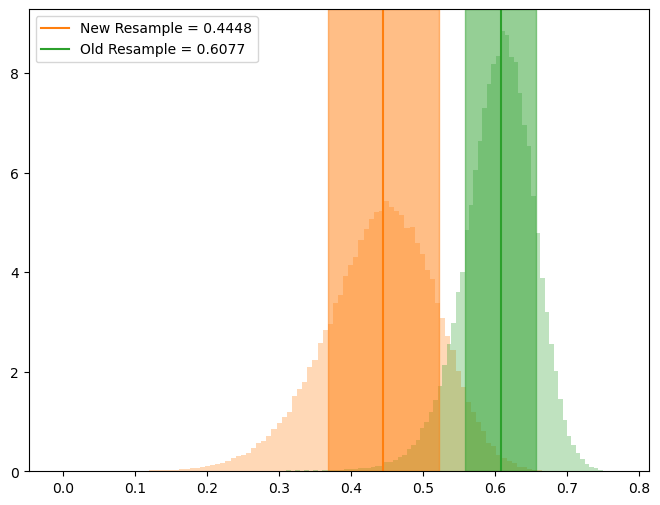

In [ ]:
new_sig=norm_zero_signal(newdata)
old_sig=norm_zero_signal(data)
new_full_matrix=covarience_matrix(newdata)
new_diagonal = remove_diag(new_full_matrix)
old_full_matrix=covarience_matrix(data)
old_diagonal=remove_diag(old_full_matrix)
plt.hist(new_diagonal,bins=100,density=True,color='C1',alpha=0.3);
plt.hist(old_diagonal,bins=100,density=True,color='C2',alpha=0.3);
newm, news = np.nanmedian(new_diagonal), np.nanstd(new_diagonal)
oldm, olds = np.nanmedian(old_diagonal), np.nanstd(old_diagonal)
label1='New Resample = '+str(round(newm,4))
label2='Old Resample = '+str(round(oldm,4))
plt.axvline(newm,color='C1',label=label1)
plt.axvspan(newm-news,newm+news,color='C1',alpha=0.5)
plt.axvline(oldm,color='C2',label=label2)
plt.axvspan(oldm-olds,oldm+olds,color='C2',alpha=0.5)
plt.legend();

In [ ]:
resampler = resample.Resampler()
resampler.load_data(newdata.year, newdata.d14c, newdata.sig_d14c)
resampler.annual = np.arange(np.ceil(resampler.start), np.floor(resampler.end + 1))
new_signal = resampler.signal_resample(size=512)
f = interp1d(resampler.x, resampler.y, kind="cubic")
interpolation = f(resampler.annual)
new_sig = resampler.bandpass_super_gaussian(interpolation, l=1./9.677, sz=0.05, order=30)

In [ ]:
resampler = resample.Resampler()
resampler.load_data(data.year, data.d14c, data.sig_d14c)
resampler.annual = np.arange(np.ceil(resampler.start), np.floor(resampler.end + 1))
old_signal = resampler.signal_resample(size=512)
f = interp1d(resampler.x, resampler.y, kind="cubic")
interpolation = f(resampler.annual)
old_sig = resampler.bandpass_super_gaussian(interpolation, l=1./9.677, sz=0.05, order=30)

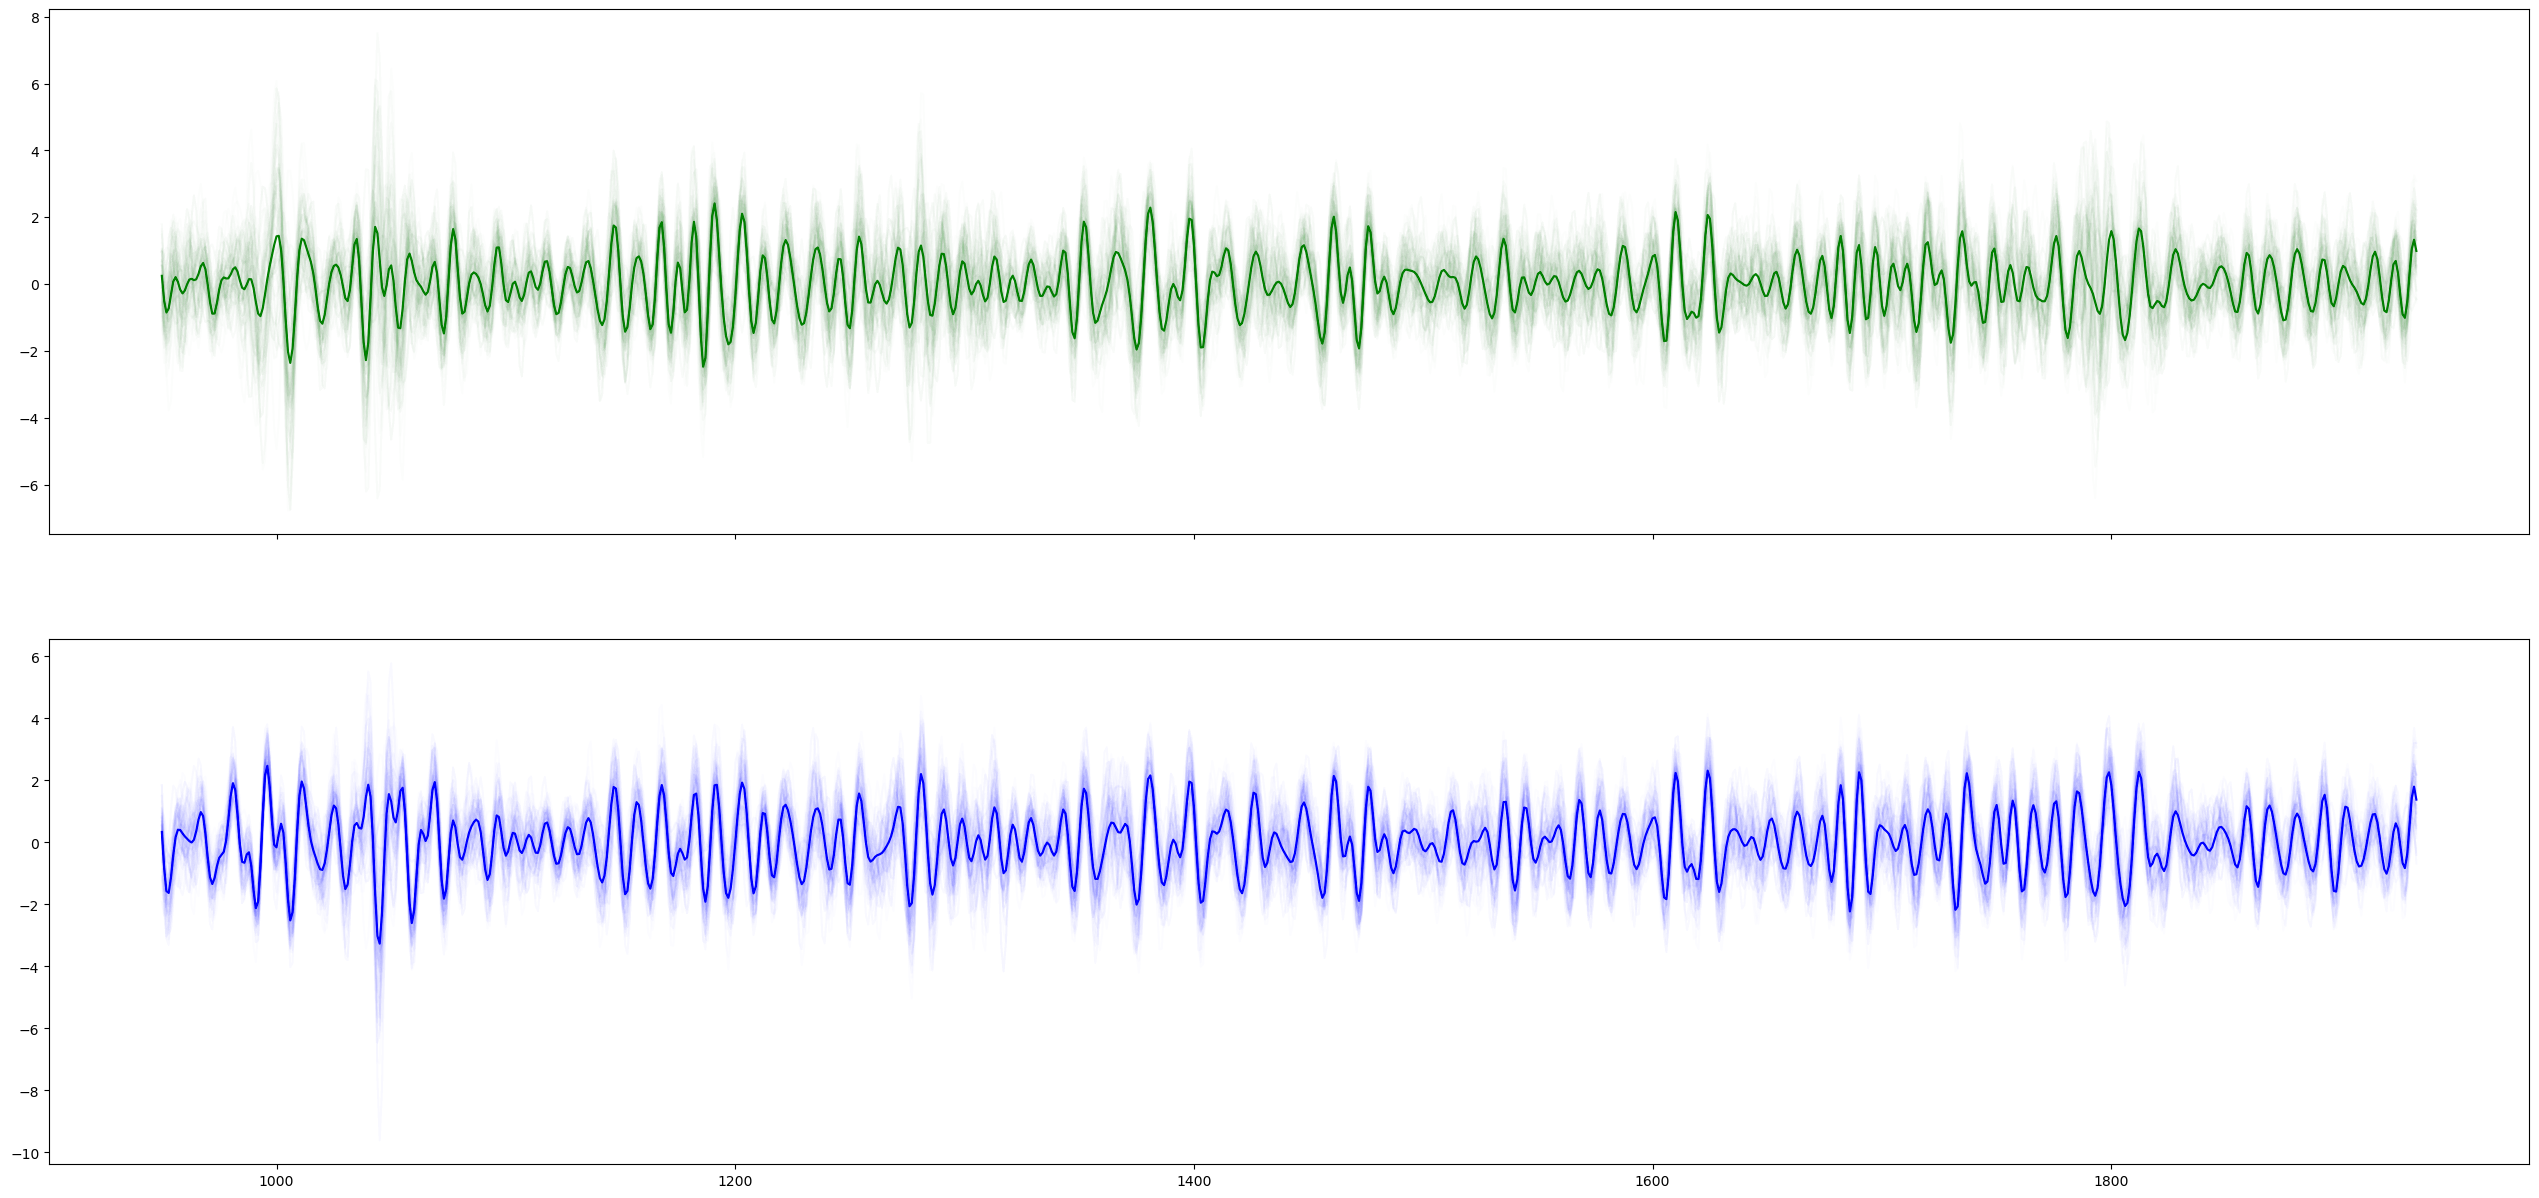

In [ ]:
fig, axs = plt.subplots(2, figsize=(32, 15), sharex=True)
axs[0].plot(resampler.annual, new_sig, color="g")
for i in np.random.randint(100, size=100):
    axs[0].plot(resampler.annual, new_signal[i, :], color="g", alpha=0.01)
axs[1].plot(resampler.annual, old_sig, color="b")
for i in np.random.randint(100, size=100):
    axs[1].plot(resampler.annual, old_signal[i, :], color="b", alpha=0.01)

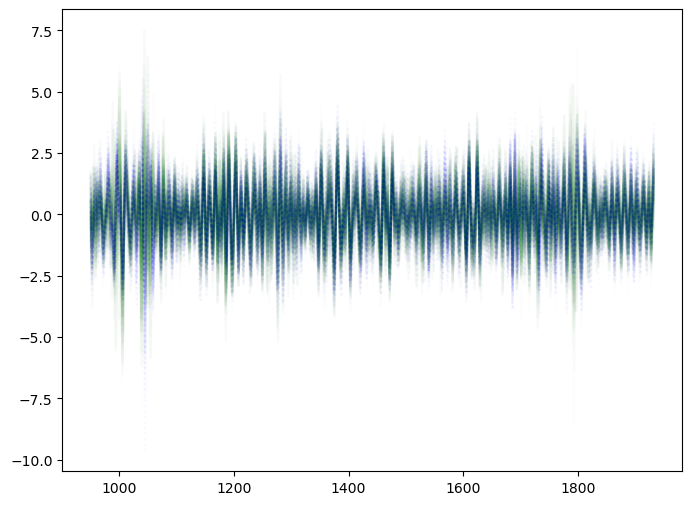

In [ ]:
for i in np.random.randint(100, size=100):
    plt.plot(resampler.annual, new_signal[i, :], color="g", alpha=0.01)
for i in np.random.randint(100, size=100):
    plt.plot(resampler.annual, old_signal[i, :], color="b", alpha=0.01,linestyle='dotted')

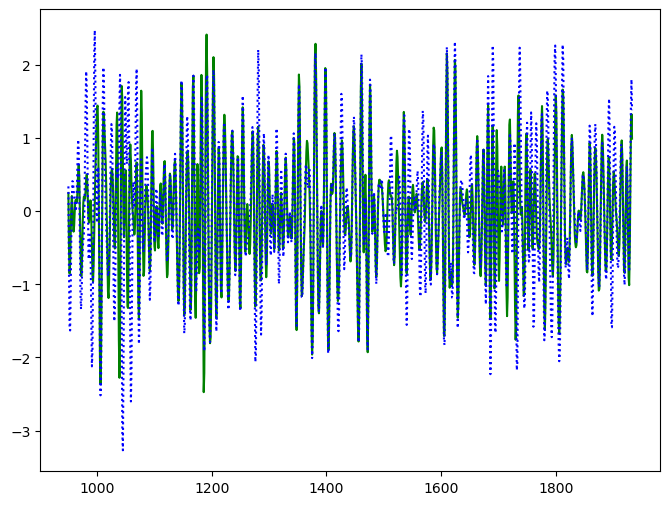

In [ ]:
plt.plot(resampler.annual, new_sig, color="g")
plt.plot(resampler.annual, old_sig, color="b",linestyle='dotted')
#plt.xlim(1000,1100);

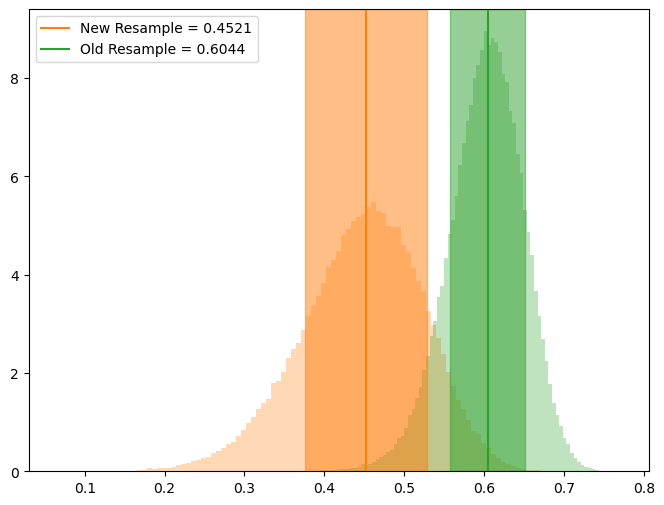

In [ ]:
new_covmat = np.corrcoef(new_signal)
new_diag = new_covmat[~np.eye(new_covmat.shape[0],dtype=bool)]
old_covmat = np.corrcoef(old_signal)
old_diag = old_covmat[~np.eye(old_covmat.shape[0],dtype=bool)]
plt.hist(new_diag,bins=100,density=True,color='C1',alpha=0.3);
plt.hist(old_diag,bins=100,density=True,color='C2',alpha=0.3);
newm, news = np.nanmedian(new_diag), np.nanstd(new_diag)
oldm, olds = np.nanmedian(old_diag), np.nanstd(old_diag)
label1='New Resample = '+str(round(newm,4))
label2='Old Resample = '+str(round(oldm,4))
plt.axvline(newm,color='C1',label=label1)
plt.axvspan(newm-news,newm+news,color='C1',alpha=0.5)
plt.axvline(oldm,color='C2',label=label2)
plt.axvspan(oldm-olds,oldm+olds,color='C2',alpha=0.5)
plt.legend();

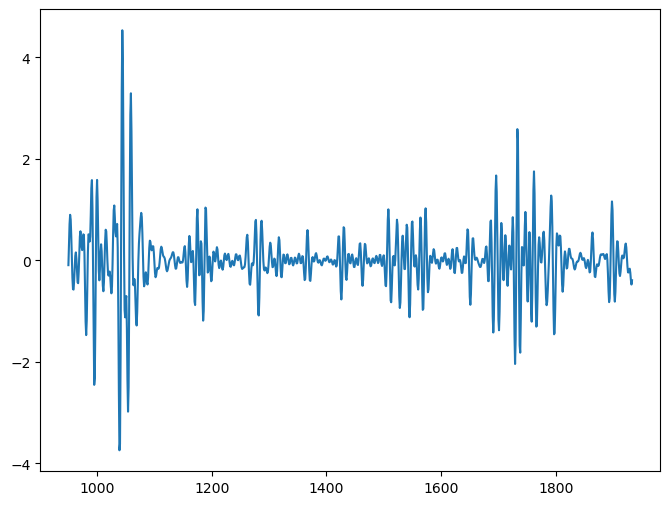

In [ ]:
resid=new_sig-old_sig
plt.plot(resampler.annual,resid)

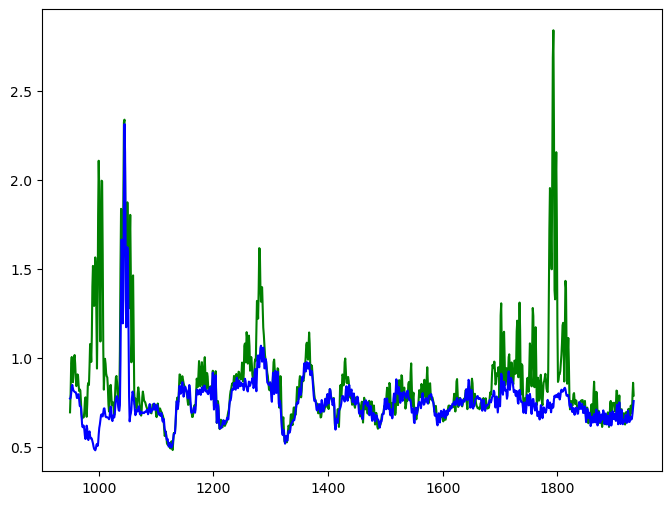

In [ ]:
plt.plot(resampler.annual1,np.std(new_signal1, axis=0),color='g')
plt.plot(resampler.annual,np.std(new_signal, axis=0),color='b')

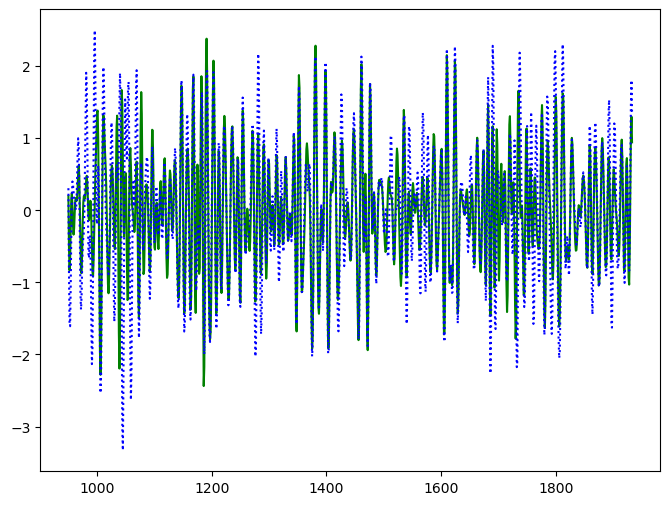

In [ ]:
plt.plot(resampler.annual1,np.mean(new_signal1,axis=0),color='g')
plt.plot(resampler.annual,np.mean(new_signal,axis=0),color='b',linestyle='dotted')

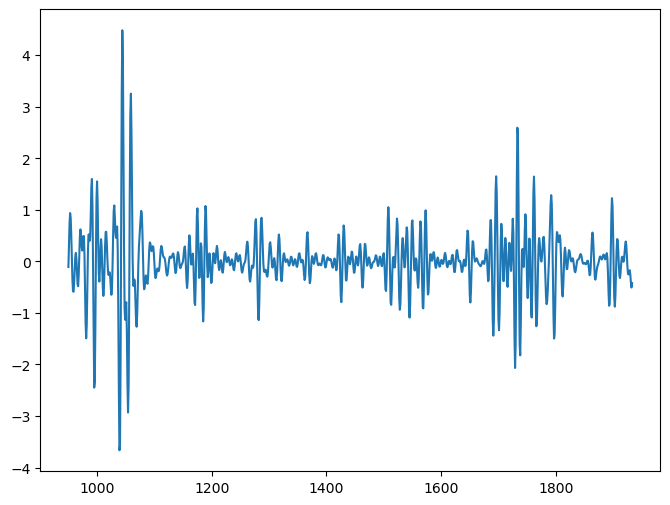

In [ ]:
residuals=np.mean(new_signal1,axis=0)-np.mean(new_signal,axis=0)
plt.plot(resampler.annual,residuals)

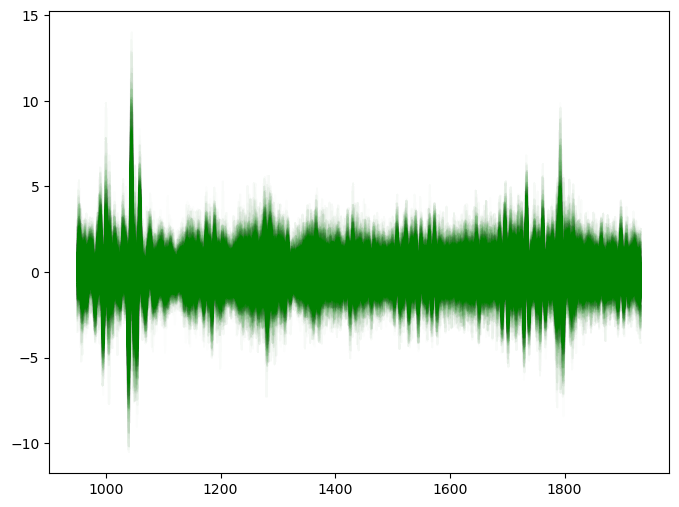

In [ ]:
#print(new_signal.shape,new_signal1.shape)
newest=new_signal1-new_signal
#print(newest.shape,resampler.annual1.shape)
for i in np.random.randint(512, size=1000):
    plt.plot(resampler.annual, newest[i, :], color="g", alpha=0.01)

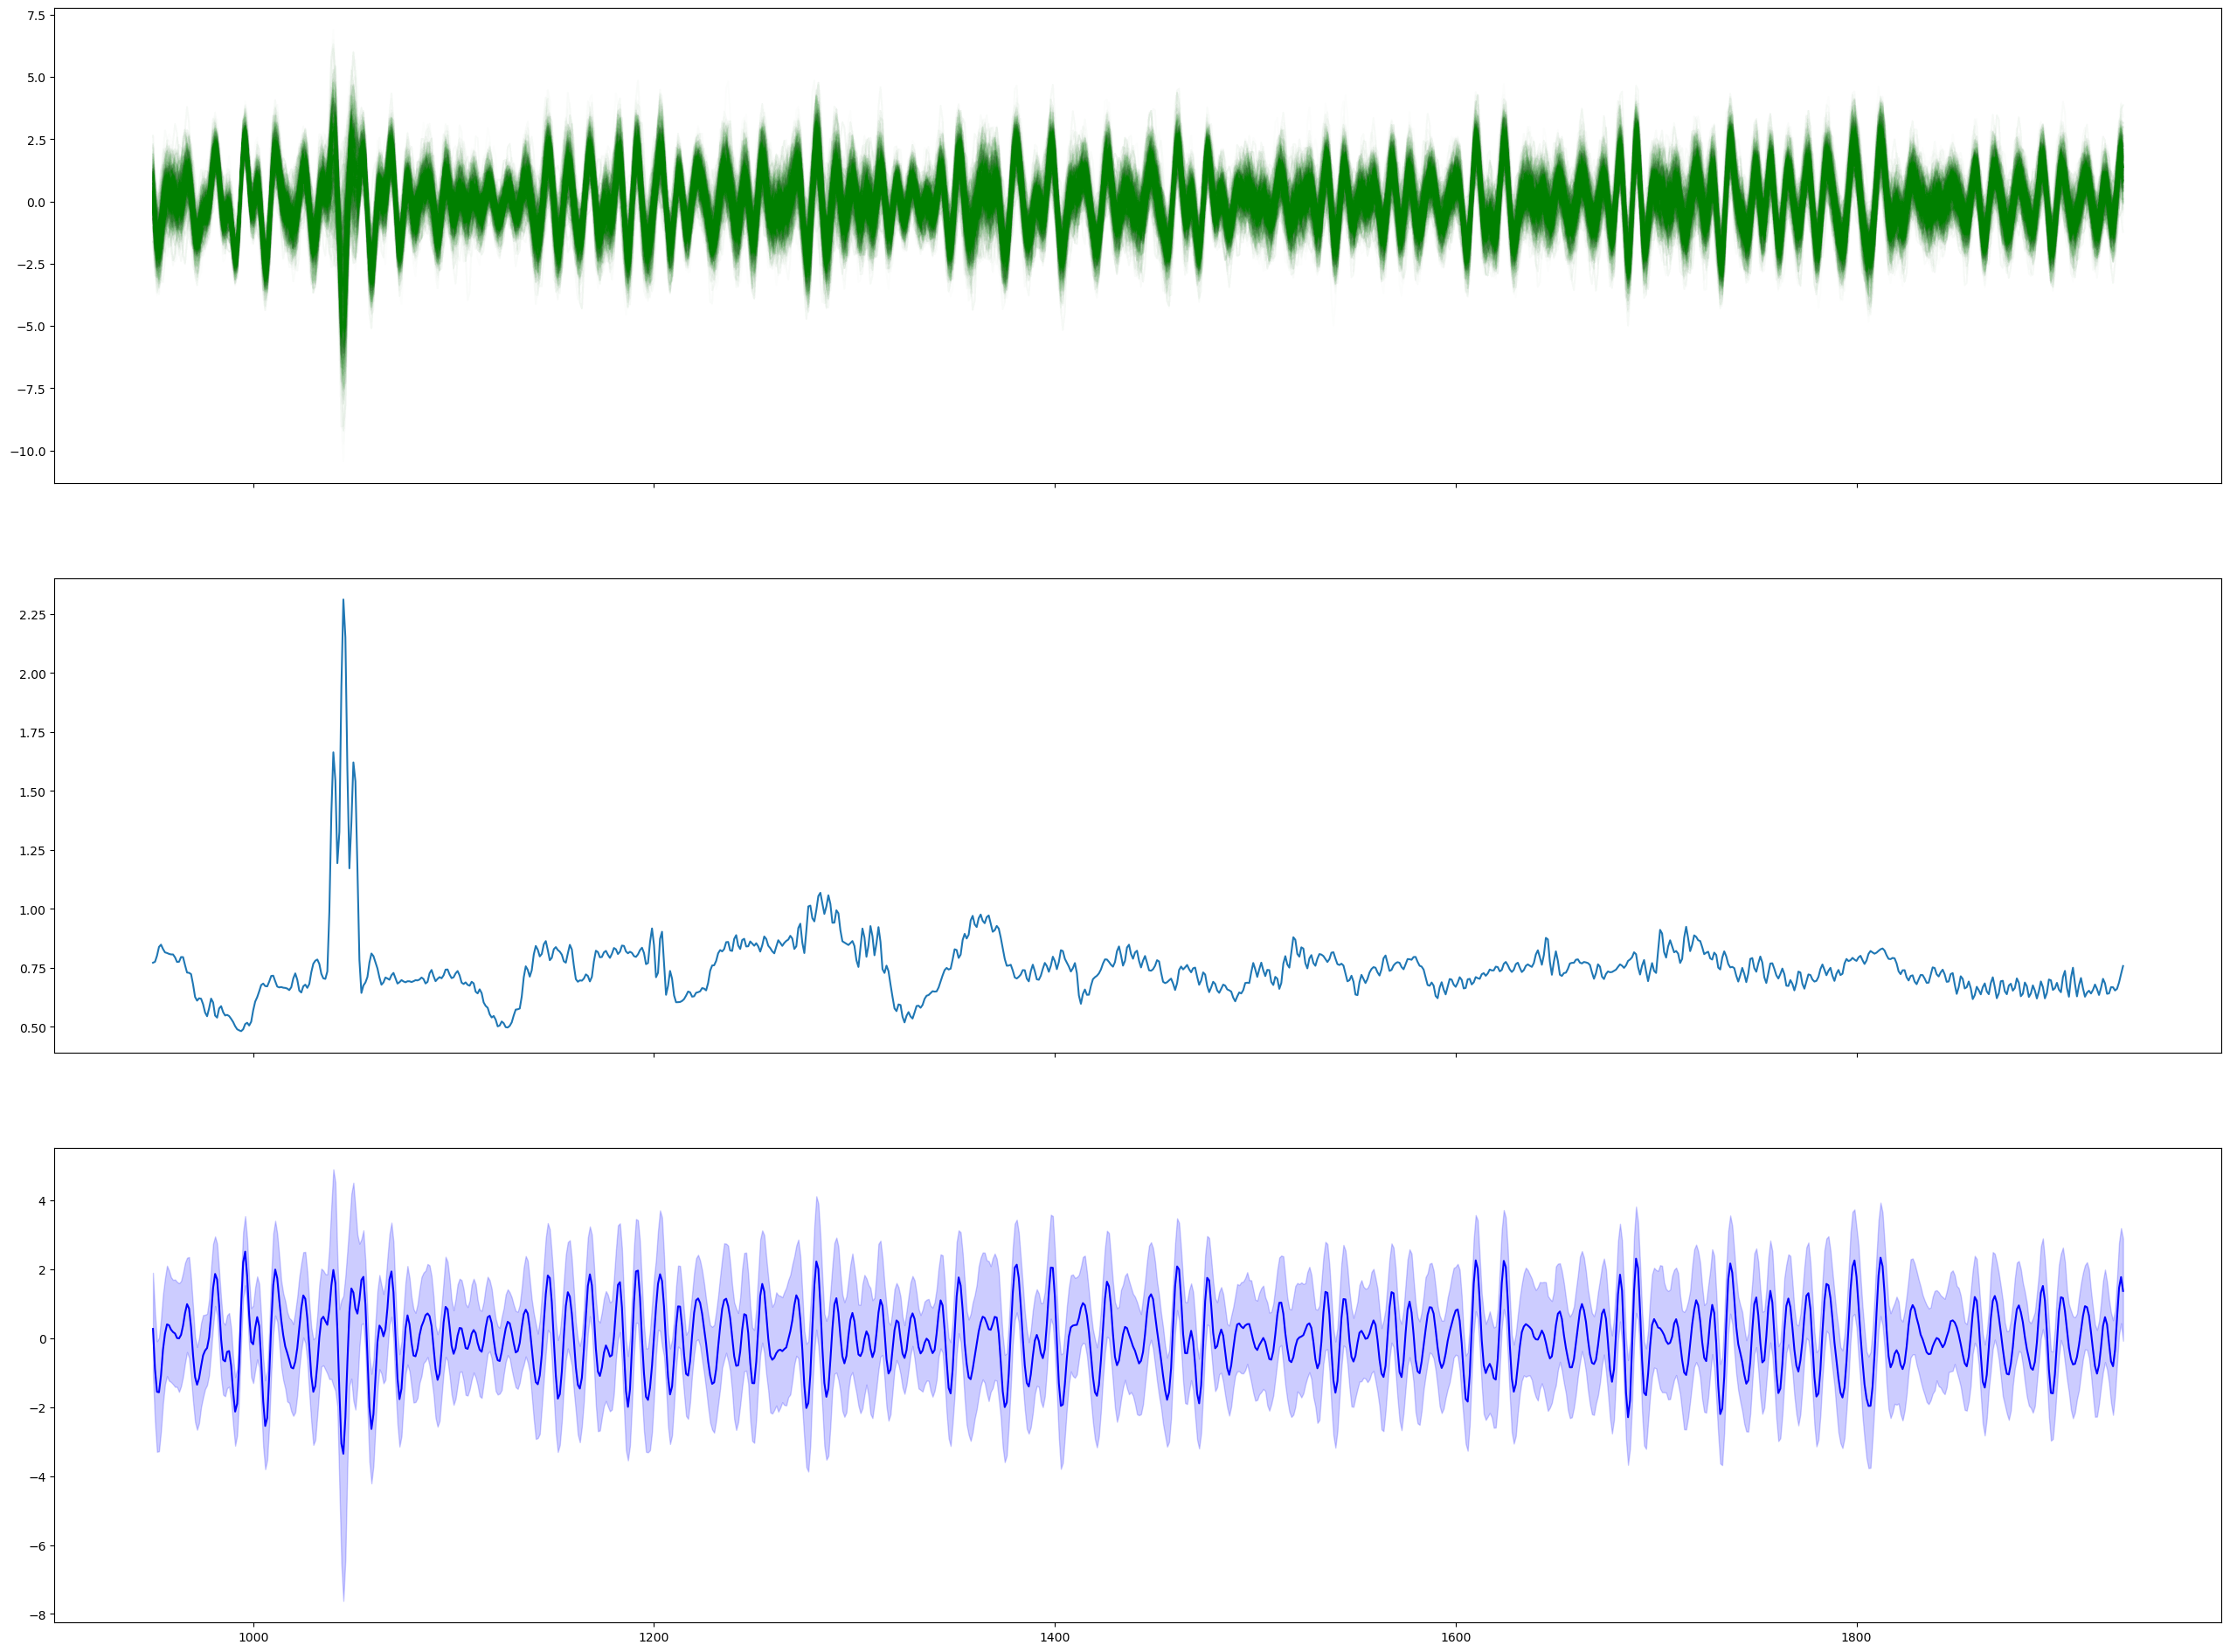

In [ ]:
fig, axs = plt.subplots(3, figsize=(32, 24), sharex=True)
for i in np.random.randint(512, size=1000):
    axs[0].plot(resampler.annual, new_signal[i, :], color="g", alpha=0.01)
axs[0].plot(resampler.annual, sig, color="g")
axs[1].plot(resampler.annual, np.std(new_signal, axis=0))
l, me, u = np.percentile(new_signal, (2.5, 50, 97.5 ), axis=0)
axs[2].fill_between(resampler.annual, l, u, color = 'b', alpha=0.2)
axs[2].plot(resampler.annual, me, color = 'b')